<a href="https://colab.research.google.com/github/samadamini/TxtNLP/blob/master/NLPdoc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers

In [2]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [3]:
from google.colab import files

uploaded = files.upload()

Saving data_doc.csv to data_doc.csv


In [0]:
import pandas as pd
import io
df = pd.read_csv(io.BytesIO(uploaded['data_doc.csv']))

In [5]:
df.dropna(subset=['Participant'],inplace=True)
df.isnull().sum()

Unnamed: 0              0
Participant             0
age_at_event            0
sex                     0
apoe                    7
diagnosis               0
cog_status_at_death    57
dtype: int64

In [6]:
df.diagnosis.loc[(df['diagnosis'] > 0)] = 1
df.diagnosis.loc[(df['diagnosis'] <= 0)] = 0


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [0]:
dfn = df.convert_dtypes()

In [8]:
dfn.dtypes

Unnamed: 0               Int64
Participant             string
age_at_event             Int64
sex                      Int64
apoe                     Int64
diagnosis                Int64
cog_status_at_death    float64
dtype: object

In [9]:
import re
def clean_txt(txt):
  txt = re.sub("'","",txt)
  txt = re.sub("(\\W)+"," ",txt)
  return txt
dfn.Participant.apply(clean_txt)

0       Single Widowed Right Button my right hand shi...
1       Very well Id like to hear that Both On the on...
2       Widow Right No I dont think so theres so many...
3       As long as youre not gonna use it against me ...
4       Okay Well I know her name was Ann Anna Thomps...
                             ...                        
187     Im divorced Right handed Not primarily I have...
188     Right handed No Our two daughters I dont thin...
189     Okay Yes Married Right handed No I only gradu...
190     Unintelligible Alright PhD Business Administr...
191     I had I had it before yeah Yeah Right Married...
Name: Participant, Length: 192, dtype: object

In [0]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(dfn,test_size=0.20, random_state=21)

In [11]:
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.head(2)

,Unnamed: 0,Participant,age_at_event,sex,apoe,diagnosis,cog_status_at_death
0,129,"I hope so. I'll tell you no, I don't, no....",80,1,34,1,3.0
1,141,"P1: We was, I thought we could go, s-, couple...",83,2,33,1,3.0


In [0]:
def get_split(text1):
  l_total = []
  l_parcial = []
  if len(text1.split())//150 >0:
    n = len(text1.split())//150
  else: 
    n = 1
  for w in range(n):
    if w == 0:
      l_parcial = text1.split()[:200]
      l_total.append(" ".join(l_parcial))
    else:
      l_parcial = text1.split()[w*150:w*150 + 200]
      l_total.append(" ".join(l_parcial))
  return l_total


In [13]:
df_train['txt_split'] = df_train['Participant'].apply(get_split)
df_test['txt_split'] = df_test['Participant'].apply(get_split)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [14]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [0]:
labels = []
for i in range(len(df_train.txt_split)):
  for j in range(len(df_train.txt_split.iloc[i])):
    label = df_train.diagnosis.iloc[i]
    labels.append(label)


In [0]:
import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []
token_type_ids = []
# For every sentence...
for j in range(len(df_train.txt_split)):
  for i in range(len(df_train.txt_split.iloc[j])):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          #sentences1[i], # Sentence to encode.
                          df_train.txt_split.iloc[j][i],
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,
                          return_token_type_ids = False,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
      #token_type_ids.append(encoded_dict['token_type_ids'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
#token_type_ids = torch.cat(token_type_ids, dim=0)
labels = torch.tensor(labels, dtype=torch.long)

# Print sentence 0, now as a list of IDs.
#print('Original: ', df_train.txt_split.iloc[0][0])
#print('Token IDs:', input_ids[0])
#print(i*j)

In [17]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
#dataset = TensorDataset(input_ids, attention_masks, labels, token_type_ids)
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

1,470 training samples
  164 validation samples


In [0]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 8

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [19]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 2, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [0]:
optimizer = AdamW(model.parameters(),
                  lr = 5e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [0]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
epochs = 3

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [0]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [0]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [24]:
import random
import numpy as np

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #b_token_type_ids = batch[3].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        #loss, logits = model(b_input_ids, 
                             #token_type_ids= b_token_type_ids, 
                             #attention_mask= b_input_mask, 
                             #labels= b_labels)
        loss, logits = model(b_input_ids,  
                             attention_mask= b_input_mask, 
                             labels= b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        #b_token_type_ids = batch[3].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            #(loss, logits) = model(b_input_ids, 
                                   #token_type_ids=b_token_type_ids, 
                                   #attention_mask=b_input_mask,
                                   #labels=b_labels)
            (loss, logits) = model(b_input_ids, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...
  Batch    40  of    184.    Elapsed: 0:00:30.
  Batch    80  of    184.    Elapsed: 0:01:01.
  Batch   120  of    184.    Elapsed: 0:01:33.
  Batch   160  of    184.    Elapsed: 0:02:05.

  Average training loss: 0.54
  Training epcoh took: 0:02:24

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.51
  Validation took: 0:00:06

======== Epoch 2 / 3 ========
Training...
  Batch    40  of    184.    Elapsed: 0:00:33.
  Batch    80  of    184.    Elapsed: 0:01:07.
  Batch   120  of    184.    Elapsed: 0:01:40.
  Batch   160  of    184.    Elapsed: 0:02:14.

  Average training loss: 0.38
  Training epcoh took: 0:02:34

Running Validation...
  Accuracy: 0.78
  Validation Loss: 0.58
  Validation took: 0:00:06

======== Epoch 3 / 3 ========
Training...
  Batch    40  of    184.    Elapsed: 0:00:34.
  Batch    80  of    184.    Elapsed: 0:01:07.
  Batch   120  of    184.    Elapsed: 0:01:41.
  Batch   160  of    184.    Elapsed: 0:02:15.



In [0]:
labels_t = []
for i in range(len(df_test.txt_split)):
  for j in range(len(df_test.txt_split.iloc[i])):
    label = df_test.diagnosis.iloc[i]
    labels_t.append(label)

In [0]:
import pandas as pd


# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for j in range(len(df_test.txt_split)):
  for i in range(len(df_test.txt_split.iloc[j])):
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          df_test.txt_split.iloc[j][i],                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 512,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )
      
      # Add the encoded sentence to the list.    
      input_ids.append(encoded_dict['input_ids'])
      
      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels_t = torch.tensor(labels_t, dtype=torch.long)

# Set the batch size.  
batch_size = 16  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels_t)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

In [0]:
prediction_dataloader = DataLoader(prediction_data)

In [28]:
print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 377 test sentences...
    DONE.


In [0]:
c = -1
acc = 0
tie = 0
for j in range(len(df_test.txt_split)):
  a = 0
  for i in range(len(df_test.txt_split.iloc[j])):
    c +=1
    if true_labels[c] == np.argmax(predictions[c]):
      if i>-1:
        a += 1
  if (a - (len(df_test.txt_split.iloc[j]))/2) >0:
    acc += 1
  elif (a  - (len(df_test.txt_split.iloc[j]))/2) == 0:
    tie += 1

In [30]:
print(f'Accuracy : {acc/len(df_test.txt_split)} \n Tie : {tie/len(df_test.txt_split)}')

Accuracy : 0.8205128205128205 
 Tie : 0.05128205128205128


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


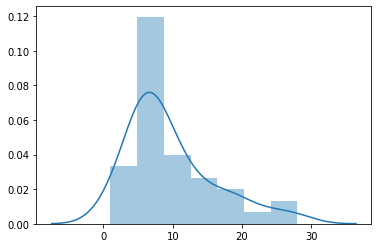

In [31]:
import seaborn as sns
ll = []
for i in range(len(df_test.txt_split)):
  li = len(df_test.txt_split.iloc[i])
  ll.append(li)

sns.distplot(ll)

In [32]:
cc = 0
for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  if pred_labels_i == true_labels[i]:
    cc += 1
print(cc/len(true_labels))

0.8275862068965517
